Importing Libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

Loading and Preprocessing the Data

In [2]:
data_path = 'archive-4/historical_stock_prices.csv'
stock_data_df = pd.read_csv(data_path, parse_dates=['date'])
stock_data_df.set_index('date', inplace=True)

Excluding Non-Numeric Columns

In [3]:
numeric_columns = stock_data_df.select_dtypes(include=[float, int]).columns
stock_data_df_numeric = stock_data_df[numeric_columns]

Feature Engineering

In [4]:
stock_data_df_numeric['returns'] = stock_data_df_numeric['close'].pct_change()
stock_data_df_numeric['volatility'] = stock_data_df_numeric['close'].pct_change().rolling(window=20).std()

Dropping Null Values

In [5]:
stock_data_df_numeric.dropna(inplace=True)

Feature Scaling

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data_df_numeric)

Splitting the Data

In [7]:
X = scaled_data[:, 1:]  # Features excluding the target variable (Close)
y = scaled_data[:, 0]   # Target variable (Close)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Reshaping Data

In [8]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Creating the GRU Model

In [9]:
model = Sequential()
model.add(GRU(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Adjust dropout rate as needed
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Training the Model

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/15
524347/524347 [==============================] - 339s 644us/step - loss: 1.2061e-07 - val_loss: 5.7326e-09
Epoch 2/15
524347/524347 [==============================] - 335s 639us/step - loss: 8.8909e-08 - val_loss: 7.7542e-09
Epoch 3/15
524347/524347 [==============================] - 336s 641us/step - loss: 9.1588e-08 - val_loss: 2.3370e-08
Epoch 4/15
524347/524347 [==============================] - 340s 648us/step - loss: 8.4373e-08 - val_loss: 9.8546e-09
Epoch 5/15
524347/524347 [==============================] - 338s 645us/step - loss: 7.5175e-08 - val_loss: 5.3359e-09
Epoch 6/15
524347/524347 [==============================] - 339s 647us/step - loss: 7.3723e-08 - val_loss: 6.1530e-09
Epoch 7/15
524347/524347 [==============================] - 339s 647us/step - loss: 7.3955e-08 - val_loss: 6.9633e-08
Epoch 8/15
524347/524347 [==============================] - 339s 647us/step - loss: 6.7776e-08 - val_loss: 4.6126e-09
Epoch 9/15
524347/524347 [==============================

Saving the Model

In [11]:
model.save('gru.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Loading the Model

In [12]:
model = load_model('gru.h5')

Evaluating Model

In [13]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Data: {mse}')

131087/131087 [==============================] - 34s 258us/step
Mean Squared Error on Test Data: 7.112794900936032e-09


Plotting Training and Validation Loss

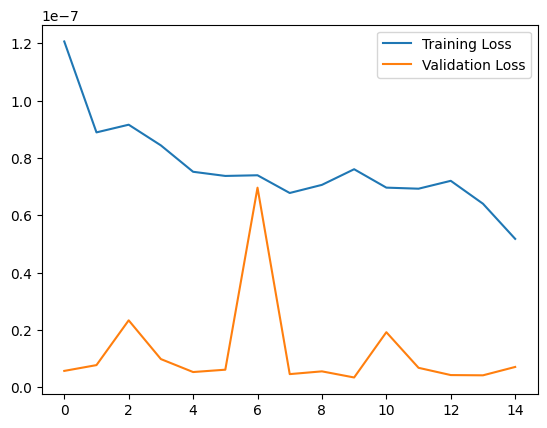

In [14]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()